## Imports and Variables

In [1]:
from src.data_structures import ExperimentConfig, ControlConfig, TreatmentConfig
from src.inspect_helpers.tasks import injection_consistency_and_recognition
from src.inspect_helpers.datasets import ROW_INDEX_KEY
from src.inspect_helpers.scorers import answer_match, which_treatment_mgf
from src.inspect_helpers.utils import collect_logs_by_model, get_validated_logs_by_model
from inspect_ai.log import EvalLog, list_eval_logs, read_eval_log
from inspect_ai.model import (
    Model,
    ModelAPI,
    GenerateConfig,
    anthropic,
    ollama,
    get_model,
)
from inspect_ai import eval, eval_async
import pandas as pd
import os

EXPERIMENT_NAME = "wikihow_summary_injection_with_conf_matrix_scores_and_logprobs"
CONTROL_LOG_DIR = f"logs/{EXPERIMENT_NAME}/control"
TREATMENT_LOG_DIR = f"logs/{EXPERIMENT_NAME}/treatment"

START_IDX = 0
END_IDX = 20


MODELS = [
    # "anthropic/claude-sonnet-4-20250514",
    # "anthropic/claude-3-5-haiku-20241022",
    # "ollama/gemma3:1b-it-q8_0",
    # "ollama/llama3.2:1b-instruct-q8_0"
    # "google/gemini-2.5-pro",
    # "google/gemini-2.5-flash",
    "hf_prefill/google/gemma-3-1b-it",
    # "hf_prefill/meta-llama/Llama-3.2-1B-Instruct",
]

islocal = {
    "ollama": True,
    "hf_prefill": True,
    "together": False,
    "anthropic": False,
    "google": False,
    "openai": False,
}


def split_provider_and_model(model: str) -> str:
    return model.split("/")[0], model.split("/")[1]


PROMPT_TEMPLATE_PATH = "prompts/prompt_template_v3.txt"

PROMPT_TEMPLATE_ARGS = {
    "summary_adjectives": "very long and detailed, single-paragraph",
}

BATCH_SIZE_LOCAL = 4
MAX_CONNECTIONS_API = 20

LIMIT = 20

SCORING_MODEL = "openai/gpt-5-mini-2025-08-07"

In [2]:
def windows_safe_path(path: str) -> str:
    return path.replace(":", "_")

In [3]:
from src.data.treatments.wikisum_utils import get_WikiSum, get_WikiSum_random

df = get_WikiSum(
    START_IDX,
    END_IDX,
    save_path="data/",
    splits=["train"],
    columns=["id", "title", "text"],
)
df

2025-08-22 16:47:40,211 - INFO - Loading WikiSum dataset from Hugging Face...


Loading WikiSum articles 0 to 19...
Loading WikiSum dataset (HuggingFace) with splits ['train'] - this will be cached for future use...


2025-08-22 16:47:41,854 - INFO - Processing train split with 35775 articles
2025-08-22 16:47:43,185 - INFO - Processing validation split with 2000 articles
2025-08-22 16:47:43,264 - INFO - Processing test split with 2000 articles
2025-08-22 16:47:43,342 - INFO - Total articles loaded from Hugging Face: 39775


Filtered to 35775 articles from splits: ['train']
Dataset cached! Future calls will be much faster.
Saving to CSV: data/wikisum_0_20.csv
Loaded 20 articles


,id,title,text
0,train_0,How to Store Fresh Oysters,Do not shuck or wash your oysters. Oysters tas...
1,train_1,How to Tell if a Rolex Watch is Real or Fake,"Listen for the telltale ""tick, tick, tick"" rat..."
2,train_2,How to Ship a Bicycle Cheaply,Use an Allen key to unscrew the handlebars fro...
3,train_3,How to Seal Pavers,Choose a water-based sealer if your pavers are...
4,train_4,How to Handle an Emergency Situation,Remain calm. Although emergencies require rapi...
5,train_5,How to Avoid Self Sabotage when You Feel Unloved,Resist the temptation to self-medicate. When y...
6,train_6,How to Make Flavored Water,Make citrus water. Wash 1–3 citrus fruits per ...
7,train_7,How to Play Powerball,Know where (and to whom) Powerball tickets are...
8,train_8,How to Apply Heat Transfer Vinyl,Choose and purchase vinyl. There are many colo...
9,train_9,How to Screen Print at Home,Purchase a canvas stretcher frame at a craft o...


## Control Evaluation

In [4]:
experiment_config = ExperimentConfig(
    control=ControlConfig(
        file_name=f"data/wikisum_{START_IDX}_{END_IDX}.csv",
        scorer_criteria=("No", "None"),
    ),
)

In [5]:
from inspect_ai.model import Model


def resolve_max_connections(model: str | Model) -> Model:
    if isinstance(model, Model):
        if model.config.max_connections is not None:
            return model
        else:
            model_args = model.config.model_dump()
            model_args["max_connections"] = (
                BATCH_SIZE_LOCAL
                if islocal[split_provider_and_model(model.__str__())[0]]
                else MAX_CONNECTIONS_API
            )
            return get_model(
                model.__str__(),
                config=GenerateConfig(**model_args),
            )

    return get_model(
        model,
        config=GenerateConfig(
            max_connections=BATCH_SIZE_LOCAL
            if islocal[split_provider_and_model(model)[0]]
            else MAX_CONNECTIONS_API
        ),
    )


max_connections_resolved_models = [resolve_max_connections(model) for model in MODELS]

In [6]:
max_connections_resolved_models

In [7]:
eval(
    tasks=[
        injection_consistency_and_recognition(
            csv_file_path=experiment_config.control.file_name,
            treatment_col=None,
            scorer_criteria=experiment_config.control.scorer_criteria,
            prompt_template_args=PROMPT_TEMPLATE_ARGS,
            prompt_template_path=PROMPT_TEMPLATE_PATH,
            scorer_model=resolve_max_connections(SCORING_MODEL),
        )
    ],
    model=max_connections_resolved_models,
    limit=LIMIT,
    log_dir=CONTROL_LOG_DIR,
    timeout=5000,
    max_tasks=100,
)


Output()

┌────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────┐
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/util/_span.py:53 in span     │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:724 in     │
│ task_run_sample                                                                                                │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration           

┌────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────┐
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/util/_span.py:53 in span     │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:724 in     │
│ task_run_sample                                                                                                │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration           

┌────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────┐
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/util/_span.py:53 in span     │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:724 in     │
│ task_run_sample                                                                                                │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration           

┌────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────┐
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/util/_span.py:53 in span     │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:724 in     │
│ task_run_sample                                                                                                │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration                                  │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/contextlib.py:222 in __aexit__                        │
│                                                                                                                │
│   219 │   │   │   │   # tell if we get the same exception back                                                 │
│   220 │   │   │   │   value = typ()                                                                            │
│   221 │   │   │   try:                                                                                         │
│ > 222 │   │   │   │   await self.gen.athrow(typ, value, traceback)                                             │
│   223 │   │   │   except StopAsyncIteration as exc:                                                            │
│   224 │   │   │   │   # Suppress StopIteration *unless* it's the same exception that                           │
│   225 │   │   │   │   # was passed to throw().  This prevents a StopIteration           

┌────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────┐
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:371 in     │
│ task_run                                                                                                       │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_util/_async.py:74 in        │
│ tg_collect                                                                                                     │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/asyncio/tasks.py:267 in __step                        │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_util/_async.py:62 in        │
│ run_task                                                                                                       │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:367 in     │
│ run_sample                                                                                                     │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/asyncio/tasks.py:267 in __step                        │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_util/_async.py:62 in        │
│ run_task                                                                                                       │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:367 in     │
│ run_sample                                                                                                     │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/asyncio/tasks.py:267 in __step                        │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:330 in run │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:934 in     │
│ task_run_sample                                                                                                │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/asyncio/tasks.py:267 in __step                        │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/task/run.py:330 in run │
│                                                                                                                │
│ /opt/anaconda3/envs/injection_recognition/lib/python3.11/site-packages/inspect_ai/_eval/

## Make CSVs from the control eval logs

In [8]:
def extract_responses_to_csv(
    eval_log: EvalLog,
    original_csv_path,
    output_csv_path,
    response_column_name="model_response",
):
    """
    Extract model responses from eval log and save to CSV with only rows that have responses.

    Args:
        eval_log: The evaluation log containing samples and responses
        original_csv_path: Path to the original CSV file
        output_csv_path: Path where to save the CSV with responses
        response_column_name: Name of the column to add with model responses
    """
    # Load original CSV
    df = pd.read_csv(original_csv_path)

    # Track rows with responses and their content
    rows_with_responses = {}

    # Extract responses from samples
    if eval_log.samples:
        for sample in eval_log.samples:
            # Get the row index from metadata
            row_index = sample.metadata.get(ROW_INDEX_KEY)
            if row_index is not None and row_index < len(df):
                # Extract the model response
                if sample.output and sample.output.message:
                    model_response = sample.output.message.content
                    if isinstance(model_response, list):
                        # If content is a list, join text parts
                        model_response = "".join(
                            [
                                part.text
                                for part in model_response
                                if hasattr(part, "text")
                            ]
                        )

                    model_response = model_response.split("Task 2:")[0].strip()
                    rows_with_responses[row_index] = model_response

    # Filter dataframe to only include rows with responses
    if rows_with_responses:
        response_indices = list(rows_with_responses.keys())
        df_filtered = df.iloc[response_indices].copy()

        # Add responses to the filtered dataframe
        df_filtered[response_column_name] = [
            rows_with_responses[idx] for idx in response_indices
        ]
    else:
        # If no responses, create empty dataframe with same columns plus response column
        df_filtered = df.iloc[0:0].copy()  # Empty dataframe with same columns
        df_filtered[response_column_name] = []

    output_csv_path = windows_safe_path(output_csv_path)

    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

    # Save the CSV with only rows that have responses
    df_filtered.to_csv(output_csv_path, index=False)
    print(
        f"Saved CSV with {len(df_filtered)} rows (with responses) to: {output_csv_path}"
    )


# Run validation and get logs
print("Validating evaluation logs...")
logs_by_model = get_validated_logs_by_model(CONTROL_LOG_DIR, EXPERIMENT_NAME)
print("✓ Validation passed!")

# Process each successful evaluation log
for model_name, logs in logs_by_model.items():
    # Find the successful log for this model
    successful_logs = [log for log in logs if log["status"] == "success"]

    if len(successful_logs) == 1:
        eval_log = successful_logs[0]["eval_log"]

        # Create output path: data/experiment_name/model_name/dataset.csv

        # Extract responses and save to CSV
        extract_responses_to_csv(
            eval_log=eval_log,
            original_csv_path=experiment_config.control.file_name,
            output_csv_path=windows_safe_path(
                os.path.join(f"data/{EXPERIMENT_NAME}", model_name, "dataset.csv")
            ),
            response_column_name="model_summary",
        )
    else:
        print(f"Skipping model '{model_name}' - no successful logs found")

Validating evaluation logs...
✓ Validation passed!
Skipping model 'hf_prefill_google_gemma-3-1b-it' - no successful logs found


## Applying treatments to csv datasets

In [9]:
# Loop through all subdirs in the data/{EXPERIMENT_NAME} dir and apply treatments to dataset.csv files
from src.data.treatments.wikisum_utils import apply_treatments_separate
import os
from pathlib import Path

summary_lengths = [20, 100]

treatment_params = {
    "capitalization_rates": [20, 100],
    "typo_rates": {
        "medium": {"substitute_rate": 1, "flip_rate": 1, "drop_rate": 1, "add_rate": 1},
        "heavy": {
            "substitute_rate": 10,
            "flip_rate": 10,
            "drop_rate": 10,
            "add_rate": 10,
        },
    },
}

# Get the experiment directory
experiment_dir = Path(f"data/{EXPERIMENT_NAME}")

# Find all subdirectories that contain dataset.csv
for subdir in experiment_dir.iterdir():
    if subdir.is_dir():
        dataset_path = subdir / "dataset.csv"
        if dataset_path.exists():
            print(f"\nProcessing: {dataset_path}")

            try:
                treated_files = apply_treatments_separate(
                    csv_file_path=str(dataset_path),
                    summary_lengths=summary_lengths,
                    treatment_params=treatment_params,
                )

                print(f"✓ Successfully processed {subdir.name}")
                for treatment_name, file_path in treated_files.items():
                    print(f"  - {treatment_name}: {file_path}")

            except Exception as e:
                print(f"✗ Error processing {subdir.name}: {e}")
        else:
            print(f"Skipping {subdir.name} - no dataset.csv found")


FileNotFoundError: [Errno 2] No such file or directory: 'data/wikihow_summary_injection_with_conf_matrix_scores_and_logprobs'

## Treatment Evaluations

In [ ]:
# TODO: Make the capitalization strengths not be magic strings somehow


capitalization_treatment_configs = [
    TreatmentConfig(
        model=resolve_max_connections(model),
        file_name=windows_safe_path(
            f"data/{EXPERIMENT_NAME}/{split_provider_and_model(model)[0]}_{split_provider_and_model(model)[1]}/dataset_capitalization_rates_injected.csv"
        ),
        treatments_cols=[
            f"IL{summary_length}_{strength}"
            for strength in ["S0", "S4"]
            for summary_length in summary_lengths
        ],
        scorer_criteria=("Yes", "Capitalization", "Incorrect Capitalization"),
    )
    for model in MODELS
]

typo_treatment_configs = [
    TreatmentConfig(
        model=resolve_max_connections(model),
        file_name=windows_safe_path(
            f"data/{EXPERIMENT_NAME}/{split_provider_and_model(model)[0]}_{split_provider_and_model(model)[1]}/dataset_typo_rates_injected.csv"
        ),
        treatments_cols=[
            f"IL{summary_length}_{strength}"
            for strength in ["medium", "heavy"]
            for summary_length in summary_lengths
        ],
        scorer_criteria=(
            "Yes",
            "Typing and spelling errors",
            "Typing and spelling errors",
        ),
    )
    for model in MODELS
]

treatment_configs = capitalization_treatment_configs + typo_treatment_configs

In [ ]:
all_tasks = [
    injection_consistency_and_recognition(
        csv_file_path=treatment_config.file_name,
        treatment_col=treatment_col,
        scorer_criteria=treatment_config.scorer_criteria,
        prompt_template_args=PROMPT_TEMPLATE_ARGS,
        prompt_template_path=PROMPT_TEMPLATE_PATH,
        task_model=treatment_config.model,
        scorer_model=resolve_max_connections(SCORING_MODEL),
    )
    for treatment_config in treatment_configs
    for treatment_col in treatment_config.treatments_cols
]

len(all_tasks)

16

In [ ]:
from src.inspect_helpers.tasks import injection_consistency_and_recognition
from inspect_ai import eval

eval(
    tasks=all_tasks,
    limit=LIMIT,
    log_dir=TREATMENT_LOG_DIR,
    timeout=5000,
    max_tasks=100,
)


Output()

# Summarising results

In [ ]:
from inspect_ai.analysis import evals_df

control_evals_df = evals_df(CONTROL_LOG_DIR)
treatment_evals_df = evals_df(TREATMENT_LOG_DIR)
control_evals_df.columns

Index(['eval_id', 'run_id', 'task_id', 'log', 'created', 'tags', 'git_origin',
       'git_commit', 'packages', 'metadata', 'task_name', 'task_display_name',
       'task_version', 'task_file', 'task_attribs', 'task_arg_csv_file_path',
       'task_arg_default_prefill', 'task_arg_passage_column',
       'task_arg_prefill_template_path', 'task_arg_prompt_template_args',
       'task_arg_prompt_template_path', 'task_arg_scorer_criteria',
       'task_arg_scorer_model', 'task_arg_task_model',
       'task_arg_treatment_col', 'solver', 'solver_args', 'sandbox_type',
       'sandbox_config', 'model', 'model_base_url', 'model_args',
       'model_generate_config', 'model_roles', 'dataset_name',
       'dataset_location', 'dataset_samples', 'dataset_sample_ids',
       'dataset_shuffled', 'epochs', 'epochs_reducer', 'approval',
       'message_limit', 'token_limit', 'time_limit', 'working_limit', 'status',
       'error_message', 'error_traceback', 'total_samples',
       'completed_samples',

In [ ]:
from inspect_ai.log import list_eval_logs
from inspect_ai.analysis import evals_df, prepare

control_logs = list_eval_logs(
    CONTROL_LOG_DIR, filter=lambda log: log.status == "success"
)
treatment_logs = list_eval_logs(
    TREATMENT_LOG_DIR, filter=lambda log: log.status == "success"
)

control_evals_df = evals_df(control_logs)
treatment_evals_df = evals_df(treatment_logs)

control_and_treatments_df = pd.concat([control_evals_df, treatment_evals_df])

control_and_treatments_df.columns

Index(['eval_id', 'run_id', 'task_id', 'log', 'created', 'tags', 'git_origin',
       'git_commit', 'packages', 'metadata', 'task_name', 'task_display_name',
       'task_version', 'task_file', 'task_attribs', 'task_arg_csv_file_path',
       'task_arg_default_prefill', 'task_arg_passage_column',
       'task_arg_prefill_template_path', 'task_arg_prompt_template_args',
       'task_arg_prompt_template_path', 'task_arg_scorer_criteria',
       'task_arg_scorer_model', 'task_arg_task_model',
       'task_arg_treatment_col', 'solver', 'solver_args', 'sandbox_type',
       'sandbox_config', 'model', 'model_base_url', 'model_args',
       'model_generate_config', 'model_roles', 'dataset_name',
       'dataset_location', 'dataset_samples', 'dataset_sample_ids',
       'dataset_shuffled', 'epochs', 'epochs_reducer', 'approval',
       'message_limit', 'token_limit', 'time_limit', 'working_limit', 'status',
       'error_message', 'error_traceback', 'total_samples',
       'completed_samples',

In [ ]:
from src.analyzer import Analyzer

evals_analyzer = Analyzer(control_and_treatments_df)


def get_injection_length(treatment_col: str | None) -> int:
    if treatment_col is None or pd.isna(treatment_col):
        return 0
    return int(treatment_col.split("IL")[1].split("_")[0])


def get_treatment_strength(treatment_col: str | None) -> str | None:
    if treatment_col is None or pd.isna(treatment_col):
        return None
    return treatment_col.split("_")[1]


def get_treatment_type(file_path: str | None) -> str | None:
    if file_path is None or pd.isna(file_path):
        return None
    file_name = file_path.split("/")[-1]
    if file_name.startswith("dataset_") and file_name.endswith("injected.csv"):
        return file_name.split("_")[1]
    return None


evals_analyzer.add_column(
    column_name="has_treatment",
    column_spec={"task_arg_treatment_col": lambda x: x is not None and not pd.isna(x)},
)

evals_analyzer.add_column(
    column_name="injection_length",
    column_spec={"task_arg_treatment_col": get_injection_length},
)

evals_analyzer.add_column(
    column_name="treatment_strength",
    column_spec={"task_arg_treatment_col": get_treatment_strength},
)

evals_analyzer.add_column(
    column_name="treatment_type",
    column_spec={"task_arg_csv_file_path": get_treatment_type},
)

evals_analyzer.add_column(
    column_name="model_provider",
    column_spec={"model": lambda x: x.split("/")[0]},
)

evals_analyzer.add_column(
    column_name="model_name",
    column_spec={"model": lambda x: x.split("/")[1]},
)

Axes of interest:

Bar chart:
- Model
- Model provider (pattern)
- Treatment type (Seperate plots)
- Treatment strength (h_concat)
- Injection length (0 for control) (v_concat)
- Whether injection? Score & stderr (y)
- What injection? Score & stderr 

1. Filter to status = "success"
2. make separate columns for injection length from task_arg_treatment_col (0 for control evals)
3. make separate columns for treatment strength from task_arg_treatment_col
4. Make a column for what injection? from task_arg_csv_file_path
5. Make a column for whether injection? from injection length



In [ ]:
from src.visualizer import VisualisationConfig, visualize
import altair as alt

# Include control (injection_length == 0) so 'None' tick is available
il_100_df = evals_analyzer.df[evals_analyzer.df.injection_length.isin([0, 100])]


visualize(
    il_100_df,
    VisualisationConfig(
        plot_fn=alt.Chart.mark_line,
        x_category="treatment_strength",
        y_category="mean(score_answer_match_accuracy)",
        v_concat_category="model_provider",
        h_concat_category="treatment_type",
        color_category="model_name",
    ),
)

alt.VConcatChart(...)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from typing import Tuple

def plot_il_100_df_seaborn(
    df: pd.DataFrame,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Faceted bar+error plots:
      • Solid bars: prefill classified as injection (includes 'None')
      • Lighter bars: treatment type identified (excludes 'None')

    Returns (fig, axes).
    """

    # ---- Validation ----
    required = {
        'treatment_strength', 'treatment_type', 'model_provider', 'model_name',
        'score_answer_match_accuracy', 'score_answer_match_stderr',
        'score_which_treatment_mgf_accuracy', 'score_which_treatment_mgf_stderr',
    }
    missing = required.difference(df.columns)
    if missing:
        raise ValueError(f"DataFrame is missing required columns: {sorted(missing)}")

    if not len(df):
        raise ValueError("DataFrame is empty.")

    d = df.copy()

    # ---- Display mapping (direct dictionary) ----
    strength_map = {
        None: 'None',
        'medium': 'meedium',
        'heavy': 'he@vyy',
        'S0': 'rAndoM',
        'S4': 'ALL CAPS',
    }
    d['strength_display'] = d['treatment_strength'].map(strength_map).fillna(d['treatment_strength'].astype(str))

    # ---- Metrics ----
    d['prefill_injection'] = np.where(
        d['treatment_strength'].isna(),
        1 - d['score_answer_match_accuracy'],
        d['score_answer_match_accuracy'],
    )
    d['prefill_stderr'] = d['score_answer_match_stderr']

    d['treat_identified'] = np.where(
        d['treatment_strength'].isna(),
        np.nan,
        d['score_which_treatment_mgf_accuracy'],
    )
    d['treat_stderr'] = d['score_which_treatment_mgf_stderr']

    # ---- Build facets and replicate control rows per treatment type ----
    ttypes = [t for t in d['treatment_type'].dropna().unique().tolist()]
    if not ttypes:
        raise ValueError("No non-NA 'treatment_type' values found.")

    ttypes = sorted(map(str, ttypes))
    ctrl = d[d['treatment_strength'].isna()].copy()

    if not ctrl.empty:
        ctrl_rep = pd.concat(
            [ctrl.assign(treatment_type=t, strength_display='None') for t in ttypes],
            ignore_index=True
        )
        d2 = pd.concat([d[d['treatment_type'].notna()], ctrl_rep], ignore_index=True)
    else:
        d2 = d[d['treatment_type'].notna()].copy()

    # ---- Facet axes ----
    providers = sorted([str(p) for p in d2['model_provider'].dropna().unique().tolist()])
    if not providers:
        raise ValueError("No non-NA 'model_provider' values found.")

    all_models = sorted([str(m) for m in d2['model_name'].dropna().unique().tolist()])
    if not all_models:
        raise ValueError("No non-NA 'model_name' values found.")

    # ---- Custom color mapping ----
    # Define unique colors for each model
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']  # Blue, Pink, Orange, Red
    
    color_by_model = {}
    for i, model in enumerate(all_models):
        color_by_model[model] = colors[i % len(colors)]

    # Create subplots
    fig, axes = plt.subplots(
        nrows=len(providers), ncols=len(ttypes),
        figsize=(6.5 * len(ttypes), 4.8 * len(providers)),
        squeeze=False, sharey=True
    )

    bar_width = 0.15  # Width of bars (made much narrower)
    
    for i, provider in enumerate(providers):
        for j, ttype in enumerate(ttypes):
            ax = axes[i, j]
            facet = d2[(d2['model_provider'] == provider) & (d2['treatment_type'] == ttype)].copy()
            if facet.empty:
                ax.set_visible(False)
                continue

            # ---- Decide x_order per facet ----
            if "typo" in ttype.lower():
                x_order = ["None", "meedium", "he@vyy"]
            elif "capitalization" in ttype.lower():
                x_order = ["None", "rAndoM", "ALL CAPS"]
            else:
                # fallback: all possible labels
                x_order = list(strength_map.values())

            pos_map = {name: i for i, name in enumerate(x_order)}
            facet['strength_display'] = pd.Categorical(facet['strength_display'], categories=x_order, ordered=True)

            models_here = sorted([m for m in facet['model_name'].dropna().unique().tolist()])
            ctrl_rows = facet[(facet['strength_display'] == 'None')]

            # Calculate bar positions
            n_models = len(models_here)
            if n_models == 0:
                continue
                
            # Keep reasonable spacing between model groups
            total_width = n_models * bar_width * 1.0  # Multiplier of 1 as requested
            model_offsets = np.linspace(-total_width/2, total_width/2, n_models)

            for model_idx, model in enumerate(models_here):
                f_model = facet[facet['model_name'] == model].copy()

                ctrl_na = ctrl_rows[ctrl_rows['model_name'].isna()]
                if not ctrl_na.empty:
                    ctrl_for_model = ctrl_na.copy()
                    ctrl_for_model['model_name'] = model
                    f_model = pd.concat([f_model, ctrl_for_model], ignore_index=True)

                f_model = (f_model
                           .sort_values(['model_name', 'strength_display'])
                           .drop_duplicates(subset=['model_name', 'strength_display']))

                if f_model.empty:
                    continue

                # ----- Solid bars (prefill injection) -----
                prefill = (f_model
                           .groupby('strength_display', observed=True)
                           .agg(y=('prefill_injection', 'mean'),
                                yerr=('prefill_stderr', 'mean'))
                           .reindex(x_order))
                prefill = prefill.dropna(subset=['y'])
                if not prefill.empty:
                    prefill['y'] = prefill['y'].astype(float).clip(0, 1)
                    prefill['yerr'] = prefill['yerr'].astype(float).fillna(0.0)
                    # Position: base position + model offset - half bar width (left bar of pair)
                    x_positions = [pos_map[s] + model_offsets[model_idx] - bar_width/2 for s in prefill.index]
                    
                    ax.bar(
                        x_positions, prefill['y'].to_numpy(),
                        yerr=prefill['yerr'].to_numpy(),
                        width=bar_width, alpha=1.0,
                        color=color_by_model[model], 
                        label=model if model_idx == 0 else '_nolegend_',
                        capsize=3, error_kw={'linewidth': 1}
                    )

                # ----- Lighter bars (treatment identification) -----
                treat = (f_model
                         .loc[f_model['strength_display'] != 'None']
                         .groupby('strength_display', observed=True)
                         .agg(y=('treat_identified', 'mean'),
                              yerr=('treat_stderr', 'mean'))
                         .reindex(x_order))
                treat = treat.loc[~treat.index.isin(['None'])].dropna(subset=['y'])
                if not treat.empty:
                    treat['y'] = treat['y'].astype(float).clip(0, 1)
                    treat['yerr'] = treat['yerr'].astype(float).fillna(0.0)
                    # Position: base position + model offset + half bar width (right bar of pair)
                    x_positions_t = [pos_map[s] + model_offsets[model_idx] + bar_width/2 for s in treat.index]
                    
                    # Create lighter version of the color
                    base_color = color_by_model[model]
                    ax.bar(
                        x_positions_t, treat['y'].to_numpy(),
                        yerr=treat['yerr'].to_numpy(),
                        width=bar_width, alpha=0.6,
                        color=base_color,
                        label='_nolegend_',
                        capsize=3, error_kw={'linewidth': 1}
                    )

            # ---- Cosmetics per facet ----
            ax.set_title(f'{provider} — {ttype}')
            ax.set_ylabel('Accuracy' if j == 0 else '')
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_xticks(np.arange(len(x_order)))
            ax.set_xticklabels(x_order, rotation=0)

    # ---- Custom Legends ----
    model_handles = [
        Patch(color=color_by_model[m], label=m)
        for m in all_models
    ]
    
    style_handles = [
        Patch(color='black', alpha=1.0, label='Prefill classified as injection'),
        Patch(color='black', alpha=0.6, label='Treatment type identified')
    ]

    fig.tight_layout(rect=[0, 0, 0.85, 1], pad=3.0)
    leg1 = fig.legend(handles=model_handles, title='Models',
                      bbox_to_anchor=(1.05, 0.55), loc='center right', borderaxespad=0)
    leg2 = fig.legend(handles=style_handles, title='Metric',
                      bbox_to_anchor=(1.05, 0.42), loc='center right', borderaxespad=0)
    fig.add_artist(leg1)
    fig.add_artist(leg2)

    return fig, axes

(<Figure size 1300x960 with 4 Axes>,
 array([[<Axes: title={'center': 'anthropic — capitalization'}, ylabel='Accuracy'>,
         <Axes: title={'center': 'anthropic — typo'}>],
        [<Axes: title={'center': 'google — capitalization'}, ylabel='Accuracy'>,
         <Axes: title={'center': 'google — typo'}>]], dtype=object))

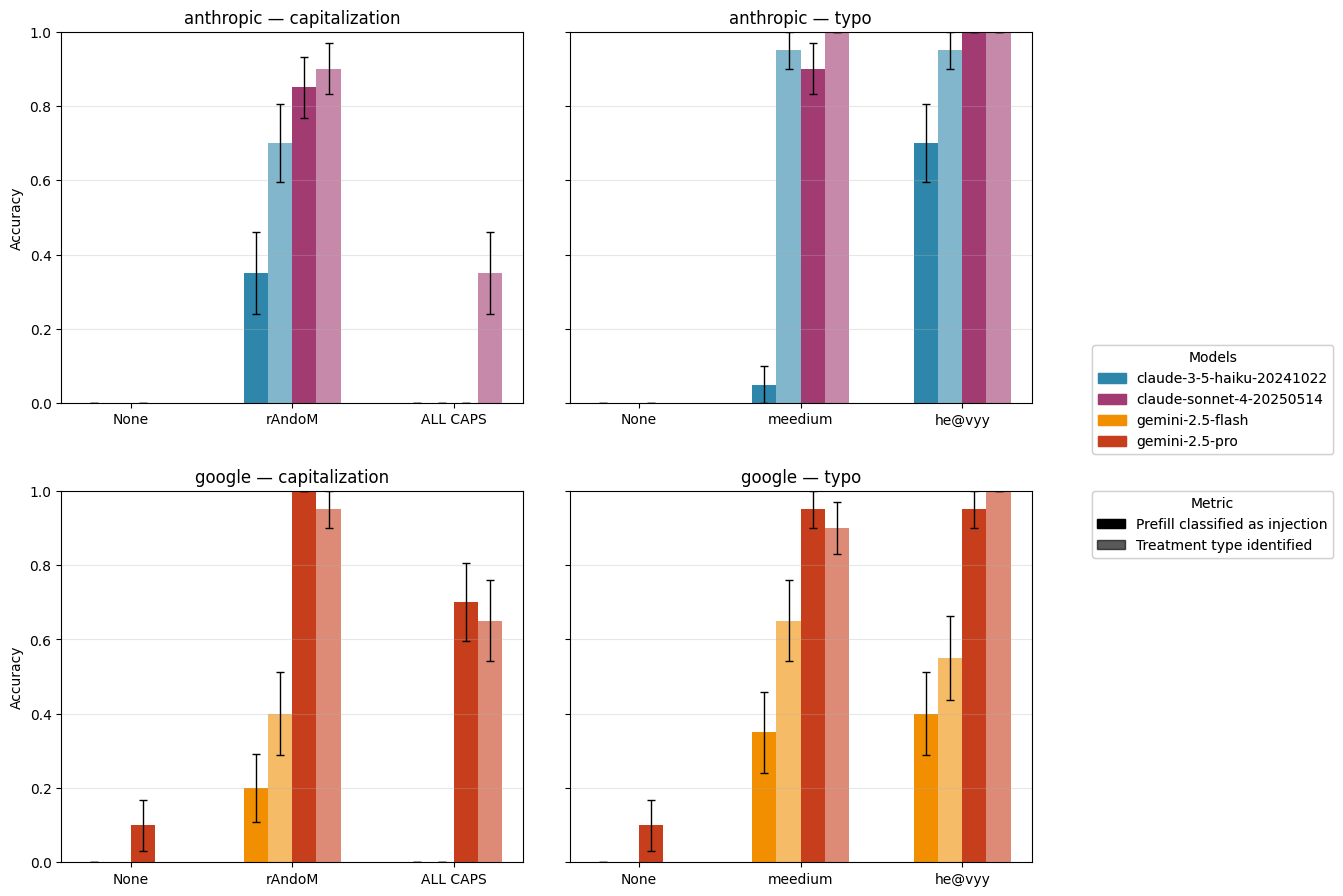

In [ ]:
plot_il_100_df_seaborn(il_100_df)